<a href="https://colab.research.google.com/github/haleema1011/AI_Flood_Warning_Nothern_Pakistan/blob/main/LSTM_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow[complete]
!pip install scikeras


## Import all the necessary libraries

In [ ]:
import pandas as pd
import requests
from io import StringIO
import ee
import tensorflow as tf
from keras import models, optimizers, layers, callbacks, backend as K
from sklearn import preprocessing
from datetime import datetime
import folium
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_df = pd.read_csv("/content/drive/MyDrive/kabul_river_met_discharge_data.csv")

In [ ]:
model_df

,Date,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
0,2005-01-01,2005.0,1.0,-0.576,-6.148,3.240,86.145,2.161,728.1
1,2005-01-02,2005.0,2.0,-0.795,-6.936,2.980,81.400,1.530,792.0
2,2005-01-03,2005.0,3.0,2.891,-8.300,2.612,68.630,0.015,514.3
3,2005-01-04,2005.0,4.0,2.906,-6.894,2.607,67.174,0.021,415.1
4,2005-01-05,2005.0,5.0,3.171,-8.099,2.550,69.000,0.097,390.6
...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,2020.0,362.0,-3.808,-12.403,2.210,78.062,0.346,223.2
5840,2020-12-28,2020.0,363.0,-1.672,-12.619,2.046,73.555,0.017,249.5
5841,2020-12-29,2020.0,364.0,1.629,-13.475,1.660,57.732,0.000,255.6
5842,2020-12-30,2020.0,365.0,3.207,-11.469,1.531,46.392,0.028,260.5


In [ ]:
len(df)

5844

# Convert 'date' to datetime and set as index

In [ ]:
model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df.set_index('Date', inplace=True)

In [ ]:
model_df.head()

,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
Date,,,,,,,,
2005-01-01,2005.0,1.0,-0.576,-6.148,3.240,86.145,2.161,728.1
2005-01-02,2005.0,2.0,-0.795,-6.936,2.980,81.400,1.530,792.0
2005-01-03,2005.0,3.0,2.891,-8.300,2.612,68.630,0.015,514.3
2005-01-04,2005.0,4.0,2.906,-6.894,2.607,67.174,0.021,415.1
2005-01-05,2005.0,5.0,3.171,-8.099,2.550,69.000,0.097,390.6


**Loss and Metrics:** The build_model function  uses 'huber_loss' for the loss and includes 'mae', 'mse', and 'mape' as metrics. below is the explanation of those.  
**Evaluation:** The evaluation step captures the Huber loss, MAE, MSE, and MAPE.
<br><br>
* **mean absolute percentage error (MAPE):** is the percentage equivalent of mean absolute error (MAE). $$ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$

* **Root Mean Squared Error (RMSE):**   $$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

* **Mean Absolute Error (MAE):** $$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i | $$

**Huber loss** is a loss function used in robust regression that is less sensitive to outliers than the squared error loss. It combines the best properties of both the Mean Squared Error (MSE) and Mean Absolute Error (MAE). The Huber loss is quadratic for small errors and linear for large errors. This makes it more robust to outliers in data compared to the MSE.

The formula for the Huber loss is defined as follows:
$$
L_\delta(a) =
\begin{cases}
\frac{1}{2}a^2 & \text{for } |a| \leq \delta \\
\delta(|a| - \frac{1}{2}\delta) & \text{for } |a| > \delta
\end{cases}
$$
Where:   
* $a = y_i - \hat{y}_i$
is the difference between the actual value and the predicted value.  
* $ \delta $ is a threshold parameter that determines the point where the loss function changes from quadratic to linear.
* The Huber loss is particularly useful when you have data with outliers, as it minimizes the impact of these outliers on the model.

<Axes: xlabel='Date'>

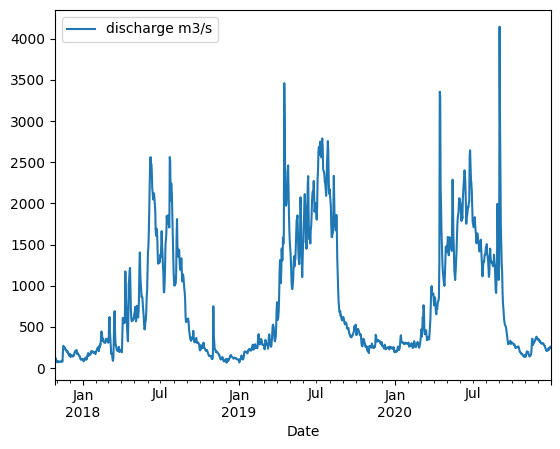

In [ ]:
model_df[-1162:].plot(y = 'discharge m3/s', use_index=True)

In [ ]:
# Split data into training and testing sets
test_split = round(len(model_df) * 0.20)

df_for_training = model_df[:-test_split]

df_for_testing = model_df[-test_split:]

print(df_for_training.shape)
print(df_for_testing.shape)

# Scale the data
scaler = RobustScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

(4675, 8)
(1169, 8)


In [ ]:
df_for_training.describe()

,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
count,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000
mean,2010.906952,180.837647,15.646034,2.414366,5.063283,53.335195,1.518895,889.808107
std,3.694487,104.630816,9.279173,8.016711,2.421018,15.595865,3.506553,786.589586
min,2005.000000,1.000000,-6.107000,-20.484000,0.696000,11.556000,0.000000,118.200000
25%,2008.000000,90.000000,7.513000,-3.764500,2.965500,41.810000,0.000000,291.800000
50%,2011.000000,180.000000,16.709000,3.361000,4.925000,51.176000,0.111000,551.100000
75%,2014.000000,270.000000,24.207000,9.378000,6.824500,63.633500,1.334500,1355.000000
max,2017.000000,366.000000,32.387000,16.210000,13.531000,95.580000,67.349000,9808.000000


In [ ]:
df_for_testing.describe()

,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
count,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000
mean,2018.875962,192.273738,14.949490,1.967625,5.051454,54.702356,1.575010,768.202917
std,0.927609,108.216086,9.216248,7.742777,2.500846,16.310297,4.239156,722.596614
min,2017.000000,1.000000,-3.808000,-16.670000,0.897000,16.424000,0.000000,64.800000
25%,2018.000000,98.000000,7.049000,-4.553000,2.862000,42.461000,0.000000,236.000000
50%,2019.000000,195.000000,15.298000,2.738000,4.638000,52.070000,0.137000,371.300000
75%,2020.000000,293.000000,23.540000,8.761000,7.037000,66.489000,1.275000,1291.000000
max,2020.000000,366.000000,31.302000,15.826000,11.249000,92.456000,71.426000,4145.000000


In [ ]:
# Create sequences
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, -1])
    return np.array(dataX), np.array(dataY)

trainX, trainY = createXY(df_for_training_scaled, 5)
testX, testY = createXY(df_for_testing_scaled, 5)

In [ ]:
trainX.shape

(4670, 5, 8)

In [ ]:
# Build the model
def build_model(optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(30, trainX.shape[2])))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae', 'mse', 'mape'])
    return model

# Wrapping the build_model function
grid_model = KerasRegressor(build_model, verbose=1)

# Define the grid search parameters
parameters = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam','sgd', 'rmsprop']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2)

# Fit the model and capture the training history
history = grid_search.fit(trainX, trainY, validation_data=(testX, testY))

# Print the best parameters and score
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_.model_
loss, mae, mse, mape = best_model.evaluate(testX, testY)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test MAPE: {mape}")

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0701 - mae: 0.2524 - mape: 246.2919 - mse: 0.1470 - val_loss: 0.0235 - val_mae: 0.1296 - val_mape: 49.5687 - val_mse: 0.0498
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0183 - mae: 0.1234 - mape: 101.1228 - mse: 0.0373 - val_loss: 0.0221 - val_mae: 0.1352 - val_mape: 77.8294 - val_mse: 0.0447
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144 - mae: 0.1091 - mape: 71.7031 - mse: 0.0289 - val_loss: 0.0145 - val_mae: 0.1037 - val_mape: 44.1250 - val_mse: 0.0300
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - mae: 0.0958 - mape: 81.5990 - mse: 0.0223 - val_loss: 0.0118 - val_mae: 0.0975 - val_mape: 45.8703 - val_mse: 0.0244
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - mae: 0.0901 - mape: 77.5074 - mse: 0.0186 - val_loss: 0.0106 - val_mae: 0.0879 - val_mape: 39.5502 - val_mse: 0.0222
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 

In [ ]:
# Make predictions
prediction = best_model.predict(testX)

# Prepare arrays for inverse scaling
n_features = trainX.shape[2]
prediction_copies_array = np.repeat(prediction, n_features, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), n_features)))[:,-1]

original_copies_array = np.repeat(testY, n_features, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), n_features)))[:,-1]

# Extract the dates for the test set
test_dates = df_for_testing.index[-len(testY):]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


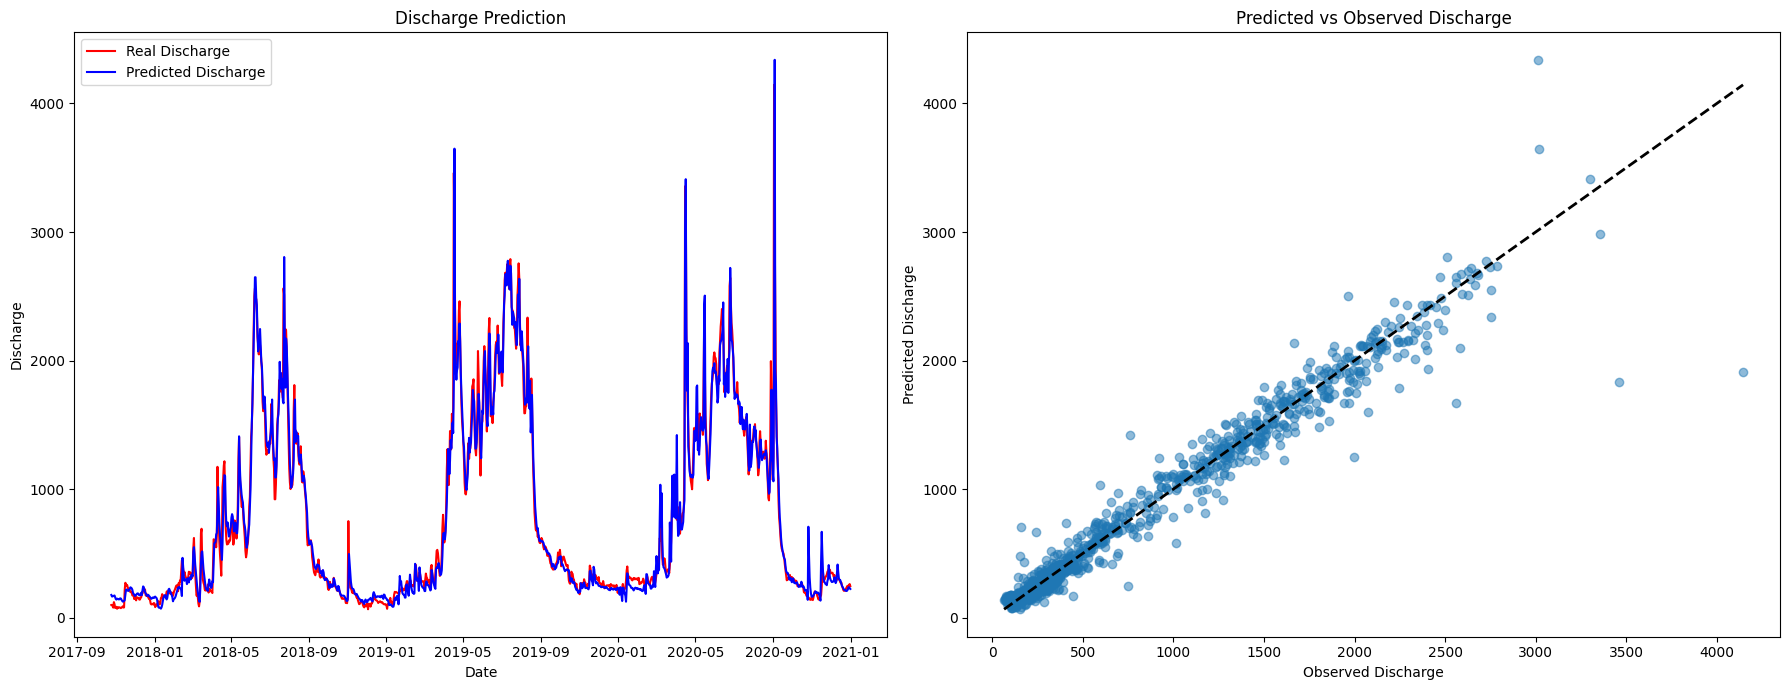

In [ ]:


# Plot time series and predicted vs observed data as subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Time series plot
axes[0].plot(test_dates, original, color='red', label='Real Discharge')
axes[0].plot(test_dates, pred, color='blue', label='Predicted Discharge')
axes[0].set_title('Discharge Prediction')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Discharge')
axes[0].legend()

# Predicted vs observed data plot
axes[1].scatter(original, pred, alpha=0.5)
axes[1].plot([original.min(), original.max()], [original.min(), original.max()], 'k--', lw=2)
axes[1].set_xlabel('Observed Discharge')
axes[1].set_ylabel('Predicted Discharge')
axes[1].set_title('Predicted vs Observed Discharge')

plt.tight_layout()
plt.show()

# Capture the training history from the best estimator
best_history = grid_search.best_estimator_.history_




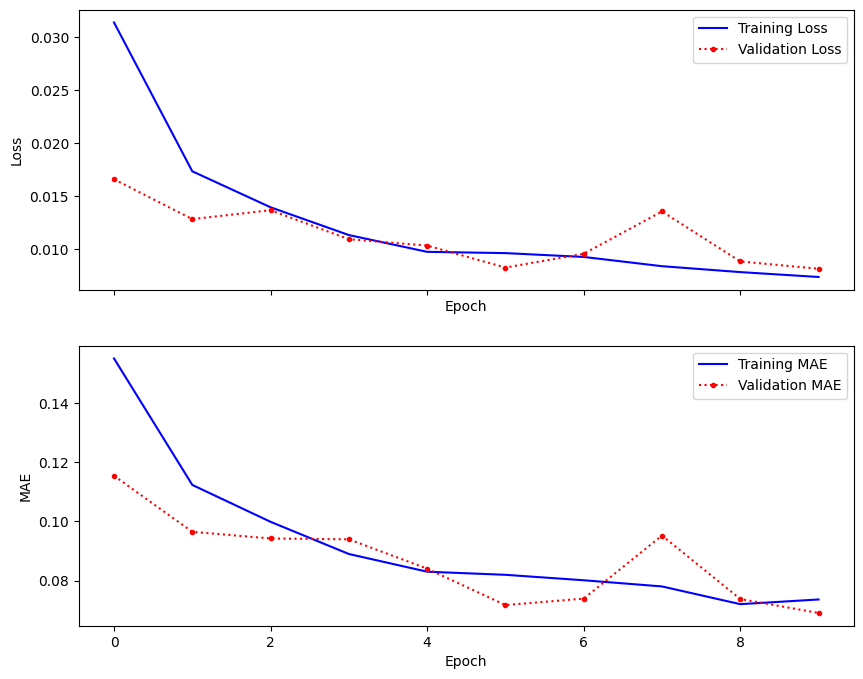

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
# Plot training & validation loss values

ax[0].plot(best_history['loss'], label='Training Loss', color='blue')
ax[0].plot(history.best_estimator_.history_['val_loss'], label='Validation Loss', color='red', linestyle=":", marker="o", markersize=3)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
# Plot training & validation MAE values
ax[1].plot(best_history['mean_absolute_error'], label='Training MAE', color='blue')
ax[1].plot(history.best_estimator_.history_['val_mae'], label='Validation MAE', color='red', linestyle=":", marker="o", markersize=3)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
plt.show()


In [ ]:
best_model.summary()

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_248 (LSTM)                      │ (None, 30, 100)             │          43,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_249 (LSTM)                      │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,555 (865.45 KB)

 Trainable params: 73,851 (288.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,704 (576.97 KB)

In [ ]:
# evaluate the performance after inverse  including r2 rmse.mae, mse

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate R-squared
r2 = r2_score(original, pred)
print(f"R-squared: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original, pred))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(original, pred)
print(f"MAE: {mae}")

# Calculate MSE
mse = mean_squared_error(original, pred)
print(f"MSE: {mse}")

R-squared: 0.9619429142777617
RMSE: 140.96167389648383
MAE: 73.4528724819852
MSE: 19870.19350769865


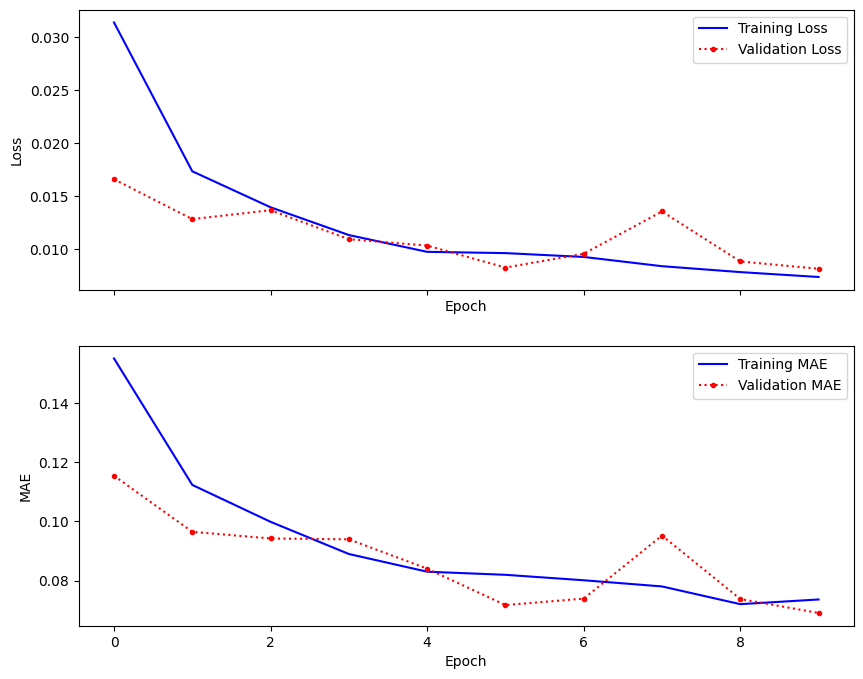

In [ ]:
#plot the test and train loss graphs

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
# Plot training & validation loss values
ax[0].plot(history.best_estimator_.history_['loss'], label='Training Loss', color='blue')
ax[0].plot(history.best_estimator_.history_['val_loss'], label='Validation Loss', color='red', linestyle=":", marker="o", markersize=3)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
# Plot training & validation MAE values
ax[1].plot(history.best_estimator_.history_['mean_absolute_error'], label='Training MAE', color='blue')
ax[1].plot(history.best_estimator_.history_['val_mae'], label='Validation MAE', color='red', linestyle=":", marker="o", markersize=3)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
plt.show()

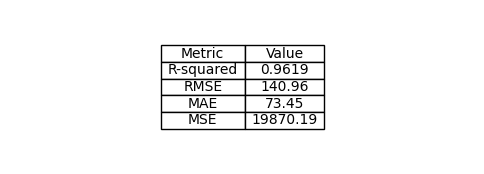

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the results
results = {
    'Metric': ['R-squared', 'RMSE', 'MAE', 'MSE'],
    'Value': [0.9619, 140.96, 73.45, 19870.19]
}

# Create a DataFrame
df = pd.DataFrame(results)

# Create the table plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Show the table
plt.show()
